In [22]:
using QuantumOptics, DiffEqNoiseProcess, PyPlot, DifferentialEquations, SparseArrays, StaticArrays, BenchmarkTools, Test

function smoothstep!(x)
    if x < 0
        return 0
    elseif x > 1
        return 1
    else
        return 3*x^2 - 2*x^3
    end
end

Nspin = 10
κ = 2π*0.15 # MHz
Δc = 2π*20 # MHz
ωz = 2π*0.01 # MHz
seed = 1729
tmax = 500.0 # μs
recordtimes = 500
tspan = range(0.0, tmax, recordtimes)

sb = SpinBasis(Nspin // 2)
Sx = sigmax(sb) / 2
Sy = sigmay(sb) / 2
Sz = sigmaz(sb) / 2
idOp = identityoperator(sb)
ψ0 = spindown(sb)
ψ0 = normalize!(ψ0)
Q0 = 0 # charge on the photodiode at time 0
cl0 = ComplexF64[Q0]
ψ_sc0 = semiclassical.State(ψ0, cl0)

stateG = copy(ψ_sc0)
dstateG = copy(ψ_sc0)
Nq = length(ψ_sc0.quantum)
Nc = length(ψ_sc0.classical)
Ntot = Nq + Nc
u0 = zeros(ComplexF64, Ntot)
semiclassical.recast!(u0, ψ_sc0)
# u0 = zeros(ComplexF64, Ntot)
# semiclassical.recast!(u0, ψ_sc0)
gc = sqrt(ωz*(Δc^2 + κ^2)/abs(Nspin*Δc))
grel!(t) = 1.1*smoothstep!(t/200.)

αplus = Δc/(-Δc + ωz - im*κ) + Δc/(-Δc - ωz - im*κ)
αminus = Δc/(-Δc + ωz - im*κ) - Δc/(-Δc - ωz - im*κ)

C0 = gc*sqrt(κ)/(2*Δc)*(αplus*Sx+im*αminus*Sy)
C!(t) = grel!(t)*C0

H0T1 = ωz*Sz
H0T2 = (gc)^2/(4*Δc)*Sx*(2*real(αplus)*Sx-2*imag(αminus)*Sy)
function H0!(t)
    return H0T1 - H0T2*(grel!(t))^2
end
function H_nl!(ψ,t)
    Ct = C!(t)
    return im * expect(dagger(Ct), normalize(ψ)) * Ct - 0.5im * dagger(Ct) * Ct - 0.5im * expect(dagger(Ct), normalize(ψ)) * expect(Ct, normalize(ψ)) * idOp
end
fdet_heterodyne!(t, ψ) = H0!(t) + H_nl!(ψ, t)
function fst_heterodyne!(t, ψ)
    Ct = C!(t)
    return [(Ct - expect(Ct, normalize(ψ))*idOp)/sqrt(2), im*(Ct - expect(Ct, normalize(ψ))*idOp)/sqrt(2)]
end

function f!(du, u, p, t)
    semiclassical.recast!(dstateG, du)
    semiclassical.recast!(stateG, u)
    timeevolution.dschroedinger_dynamic!(dstateG.quantum, fdet_heterodyne!, stateG.quantum, t)
    dstateG.classical[1] = expect(C!(t), normalize!(stateG.quantum))
    semiclassical.recast!(du, dstateG)
end

num_noise = length(fst_heterodyne!(0., ψ_sc0.quantum))
noise_prototype = zeros(ComplexF64, (Ntot, num_noise))

function g!(du, u, p, t)
    semiclassical.recast!(stateG, u)
    dx = @view du[1:Nq,:]
    stochastic.dschroedinger_stochastic(dx, t, stateG.quantum, fst_heterodyne!, dstateG.quantum, num_noise)
    du[Nq+1, 1] = 1.0/sqrt(2)
    du[Nq+1, 2] = 1.0im/sqrt(2)
    du
end

Base.@pure pure_inference(fout,T) = Core.Compiler.return_type(fout, T)

function fout(t, state)
    copy(state)
end
function fout_(x, t, integrator)
    semiclassical.recast!(stateG,x)
    copy(stateG)
end

out_type = pure_inference(fout, Tuple{eltype(tspan),typeof(ψ_sc0)})
dts = (2//1) .^(-12:-2)
psi_ts = Vector{Vector{out_type}}(undef, 0)
err_ts = Vector{Vector{Float64}}(undef, 0)
sol_times = Vector{Float64}(undef, 0)
tout_course = nothing

CurrW = RealWienerProcess!(0.0, zeros(num_noise))
for dt in dts
    function norm_func(u, t, integrator) 
        semiclassical.recast!(stateG, u)
        normalize!(stateG)
        semiclassical.recast!(u, stateG)
    end
    ncb = DiffEqCallbacks.FunctionCallingCallback(norm_func;
                func_everystep=true,
                func_start=false)
    out = DiffEqCallbacks.SavedValues(eltype(tspan),out_type)
    scb = DiffEqCallbacks.SavingCallback(fout_,out,saveat=tspan,
                                            save_everystep=false,
                                            save_start = false,
                                            tdir = first(tspan)<last(tspan) ? one(eltype(tspan)) : -one(eltype(tspan)))
    full_cb = OrdinaryDiffEq.CallbackSet(nothing, ncb, scb)
    prob = SDEProblem(f!,g!, u0, (tspan[begin], tspan[end]); noise_rate_prototype=noise_prototype, noise=CurrW)
    sol_time = @elapsed sol1 = solve(prob, RKMilGeneral(;ii_approx=IICommutative());
                adaptive=false,
                dt=dt,
                save_everystep=false,
                save_start=false,
                save_end=false,
                saveat=tspan,
                callback=full_cb, seed=seed)

    CurrW = NoiseWrapper(CurrW)

    curr_psi_t = copy(out.saveval)
    push!(psi_ts, curr_psi_t)
    if dt == dts[end]
        tout_course = copy(out.t)
    end
    curr_psi_t_q = map(x->x.quantum, curr_psi_t); base_psi_t_q = map(x->x.quantum, psi_ts[begin]);
    curr_diff_t = curr_psi_t_q - base_psi_t_q
    curr_err_t = map(x->sqrt(real(dagger(x)*x)), curr_diff_t)
    push!(err_ts, curr_err_t)
    push!(sol_times, sol_time)
end

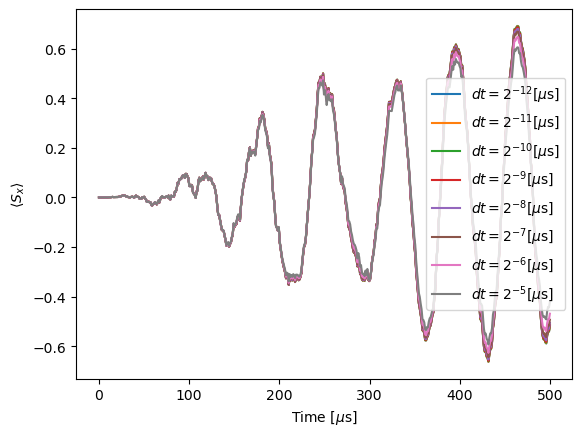

In [6]:
for i in eachindex(psi_ts[begin:end-3])
    plot(tout_course, expect(Sx, psi_ts[i])./expect(idOp, psi_ts[i]), label="\$dt=2^{$(Int(log(2, dts[i])))}\$[\$\\mu\$s]")
end
ylabel(L"$\langle S_x \rangle$")
xlabel(L"Time [$\mu$s]")
legend()
PyPlot.display_figs()

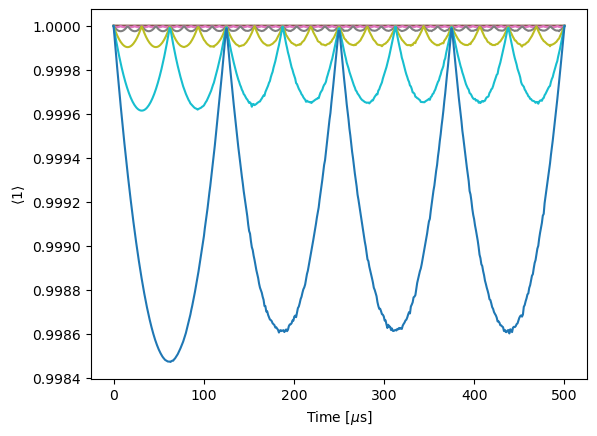

In [35]:
for i in eachindex(psi_ts[begin:end])
    plot(tout_course, expect(idOp, psi_ts[i]), label="\$dt=2^{$(Int(log(2, dts[i])))}\$[\$\\mu\$s]")
end
ylabel(L"$\langle 1 \rangle$")
xlabel(L"Time [$\mu$s]")
# legend()
PyPlot.display_figs()

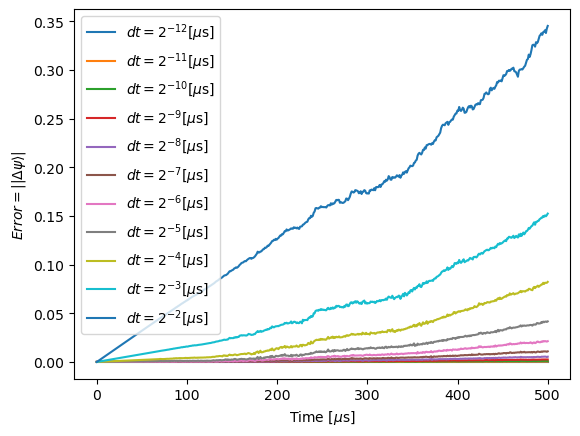

In [24]:
for i in eachindex(psi_ts[begin:end])
    plot(tout_course, err_ts[i], label="\$dt=2^{$(Int(log(2, dts[i])))}\$[\$\\mu\$s]")
end
ylabel(L"Error= || \Delta \psi \rangle |")
xlabel(L"Time [$\mu$s]")
legend()
PyPlot.display_figs()

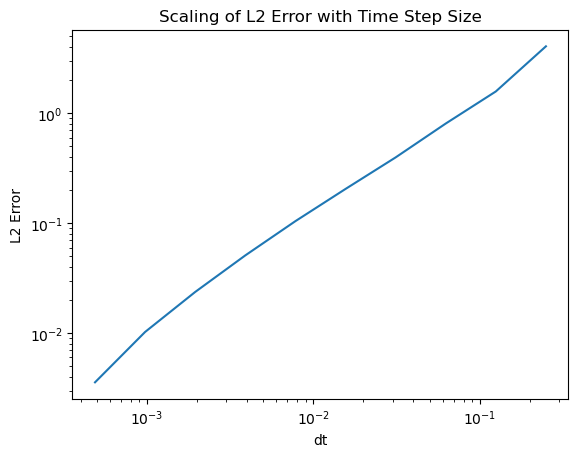

In [96]:
l2_errs = Vector{Float64}(undef, 0)
for i in eachindex(psi_ts[begin:end])
    push!(l2_errs, sqrt(sum(err_ts[i] .^2)))
end
PyPlot.loglog(dts[begin+1:end], l2_errs[begin+1:end])
ylabel("L2 Error")
xlabel("dt")
title("Scaling of L2 Error with Time Step Size")
PyPlot.display_figs()

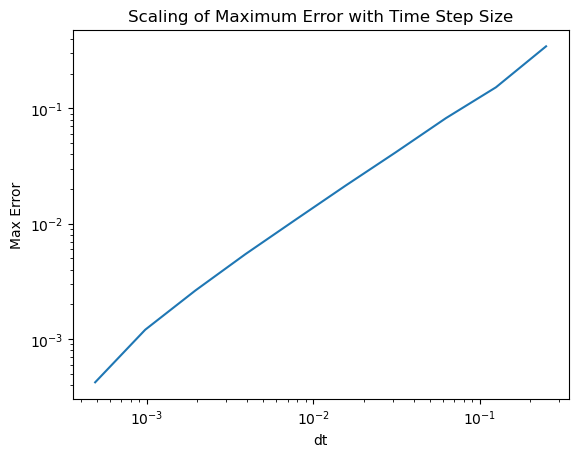

In [34]:
max_errs = Vector{Float64}(undef, 0)
for i in eachindex(psi_ts[begin:end])
    push!(max_errs, max(err_ts[i]...))
end
PyPlot.loglog(dts[begin+1:end], max_errs[begin+1:end])
ylabel("Max Error")
xlabel("dt")
title("Scaling of Maximum Error with Time Step Size")
PyPlot.display_figs()

Max error = $\max_{0\leq k \leq N} |\ket{\psi_{approx}(k\Delta t)} - \ket{\psi_{exact}(k\Delta t)}|$

L2 error = $\sqrt{\sum_{k=0}^N |\ket{\psi_{approx}(k\Delta t)} - \ket{\psi_{exact}(k\Delta t)}|^2}$

In [84]:
reltols = (10//1) .^(-8:-3)
ad_psi_ts = Vector{Vector{out_type}}(undef, 0)
ad_err_ts = Vector{Vector{Float64}}(undef, 0)
ad_sol_times = Vector{Float64}(undef, 0)
ad_tout_course = nothing


for reltol in reltols
    function norm_func(u, t, integrator) 
        semiclassical.recast!(stateG, u)
        normalize!(stateG)
        semiclassical.recast!(u, stateG)
    end
    ncb = DiffEqCallbacks.FunctionCallingCallback(norm_func;
                func_everystep=true,
                func_start=false)
    out = DiffEqCallbacks.SavedValues(eltype(tspan),out_type)
    scb = DiffEqCallbacks.SavingCallback(fout_,out,saveat=tspan,
                                            save_everystep=false,
                                            save_start = false,
                                            tdir = first(tspan)<last(tspan) ? one(eltype(tspan)) : -one(eltype(tspan)))
    full_cb = OrdinaryDiffEq.CallbackSet(nothing, ncb, scb)
    prob = SDEProblem(f!,g!, u0, (tspan[begin], tspan[end]); noise_rate_prototype=noise_prototype, noise=CurrW)
    sol_time = @elapsed sol1 = solve(prob, RKMilCommute();
                adaptive=true,
                dt=1//2^(10),
                reltol = reltol,
                abstol = reltol,
                save_everystep=false,
                save_start=false,
                save_end=false,
                saveat=tspan,
                callback=full_cb, seed=seed)

    CurrW = NoiseWrapper(CurrW)

    curr_psi_t = copy(out.saveval)
    push!(ad_psi_ts, curr_psi_t)
    tout_course = copy(out.t)
    curr_psi_t_q = map(x->x.quantum, curr_psi_t); base_psi_t_q = map(x->x.quantum, psi_ts[begin]);
    curr_diff_t = curr_psi_t_q - base_psi_t_q
    curr_err_t = map(x->sqrt(real(dagger(x)*x)), curr_diff_t)
    push!(ad_err_ts, curr_err_t)
    push!(ad_sol_times, sol_time)
end

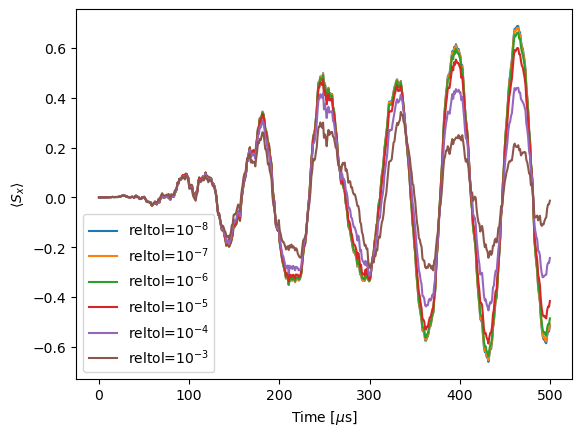

In [87]:
for i in eachindex(ad_psi_ts[begin:end])
    plot(tout_course, expect(Sx, ad_psi_ts[i]), label="reltol=\$10^{$(Int(round(log(reltols[i])/log(10))))}\$")
end
ylabel(L"$\langle S_x \rangle$")
xlabel(L"Time [$\mu$s]")
legend()
PyPlot.display_figs()

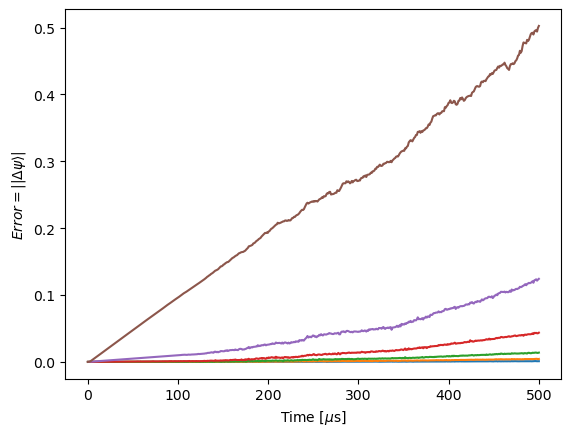

In [88]:
for i in eachindex(ad_psi_ts[begin:end])
    plot(tout_course, ad_err_ts[i], label="reltol=\$10^{$(Int(round(log(reltols[i])/log(10))))}\$")
end
ylabel(L"Error= || \Delta \psi \rangle |")
xlabel(L"Time [$\mu$s]")
# legend()
PyPlot.display_figs()

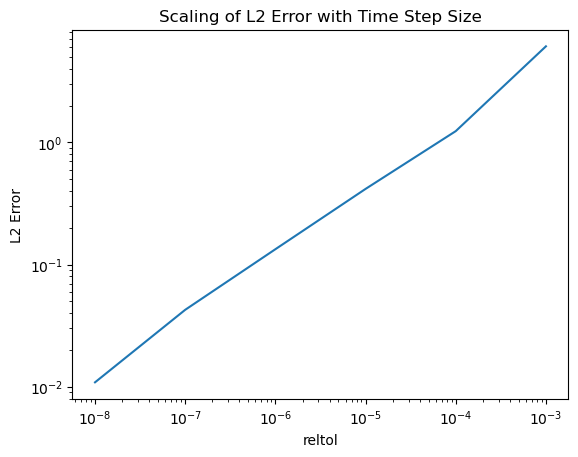

In [89]:
ad_l2_errs = Vector{Float64}(undef, 0)
for i in eachindex(ad_psi_ts[begin:end])
    push!(ad_l2_errs, sqrt(sum(ad_err_ts[i] .^2)))
end
PyPlot.loglog(reltols[begin:end], ad_l2_errs[begin:end])
ylabel("L2 Error")
xlabel("reltol")
title("Scaling of L2 Error with Time Step Size")
PyPlot.display_figs()

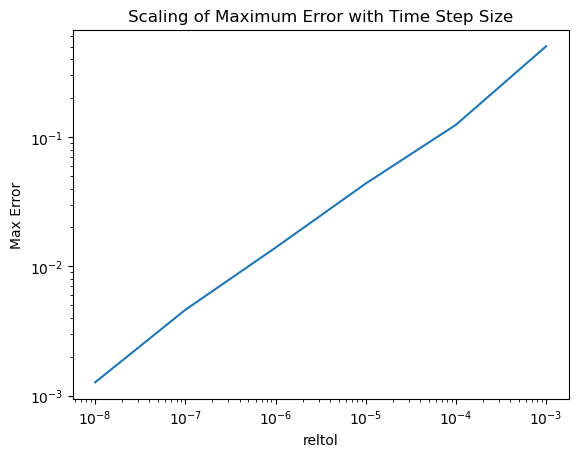

In [98]:
ad_max_errs = Vector{Float64}(undef, 0)
for i in eachindex(ad_psi_ts[begin:end])
    push!(ad_max_errs, max(ad_err_ts[i]...))
end
PyPlot.loglog(reltols[begin:end], ad_max_errs[begin:end])
ylabel("Max Error")
xlabel("reltol")
title("Scaling of Maximum Error with Time Step Size")
PyPlot.display_figs()

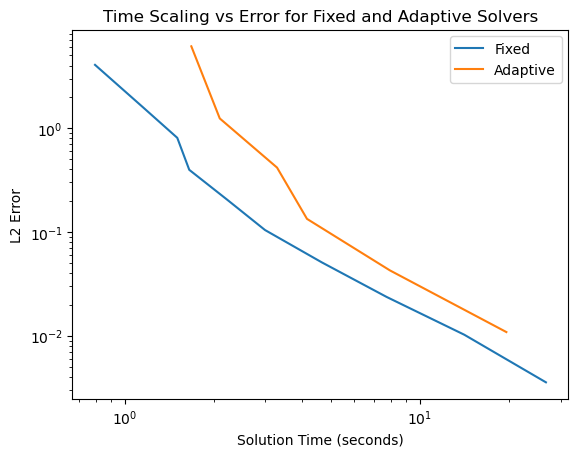

In [117]:
PyPlot.loglog(sol_times[begin+1:end], l2_errs[begin+1:end], label="Fixed")
PyPlot.loglog(ad_sol_times, ad_l2_errs, label="Adaptive")
xlabel("Solution Time (seconds)")
ylabel("L2 Error")
legend()
title("Time Scaling vs Error for Fixed and Adaptive Solvers")
PyPlot.display_figs()

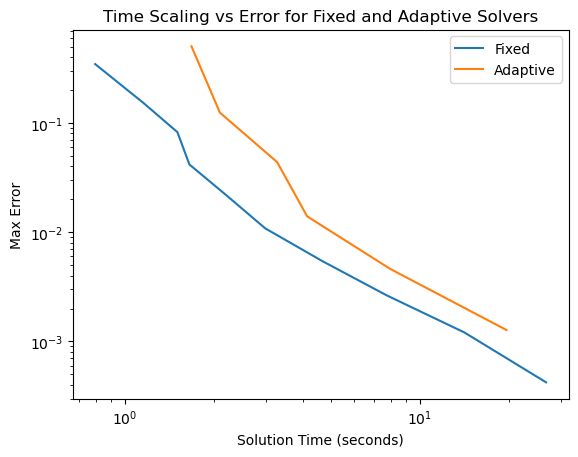

In [118]:
PyPlot.loglog(sol_times[begin+1:end], max_errs[begin+1:end], label="Fixed")
PyPlot.loglog(ad_sol_times, ad_max_errs, label="Adaptive")
xlabel("Solution Time (seconds)")
ylabel("Max Error")
legend()
title("Time Scaling vs Error for Fixed and Adaptive Solvers")
PyPlot.display_figs()

In [100]:
curve_fit(LinearFit, log.(reltols)/log(10), log.(ad_max_errs)/log(10))

LinearFit{Float64}((1.1839852660065433, 0.5077252109402588))

In [ ]:
ad_l2_errs = Vector{Float64}(undef, 0)
for i in eachindex(ad_psi_ts[begin:end])
    push!(ad_l2_errs, sqrt(sum(ad_err_ts[i] .^2)))
end
PyPlot.loglog(reltols[begin:end], ad_l2_errs[begin:end])
ylabel("L2 Error")
xlabel("reltol")
title("Scaling of L2 Error with Time Step Size")
PyPlot.display_figs()